In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path
import yaml
import re

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model4
ndbs
Mon Nov 15 14:55:49 PST 2021


# Changes from 4.5.2 to 4.5.3:

- mild->TMREL recovery rate updated from 1/1000 to 1/27.
- x-factor effects: i3=1, i2=3.16, i1=3.16.
- X-factor exposure dependent on wasting state at initialization: sam=0.6, mam=0.5, mild=0.25, tmrel=0.01

Also, Rajan identified the following bug (posted in Slack on Thu 11/4):

> i'm looking at the code now, and i think i am not calculating the x-factor paf correctly. it's being calculated based on an x-factor exposure of 22.155%, which i think must be an old value. the exposure should be dynamically calculated using wasting exposure and thie configurations for their effect on x-factor

So the results here will likely change after the bug is fixed.

# Load and clean data

Don't add `x_factor_effect` to index columns this time since it doesn't exist in this run.

In [2]:
data = csr.VivariumResults.cleaned_from_model_spec('4.5.3')
data.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [3]:
#vp.set_global_index_columns(vp.INDEX_COLUMNS+['x_factor_effect'])
vp.INDEX_COLUMNS

['input_draw', 'scenario']

# Create a dictionary to store figures to save later

In [4]:
figs = {}

In [5]:
!ls /ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/

v2.1_gbd_2020_wasting	       v2.5_stunting
v2.3_wasting_birth_prevalence  v4.5.2_x_factor
v2.4_corrected_fertility       v4.5.3_x_factor_targeted_exposure


# Compute x-factor prevalence by age group and year

In [6]:
data.person_time

,age,input_draw,measure,scenario,sex,sq_lns,wasting_treatment,x_factor,year,value
0,1-5_months,29,person_time,baseline,female,covered,covered,cat1,2022,0.000000
1,1-5_months,29,person_time,baseline,female,covered,covered,cat1,2023,0.000000
2,1-5_months,29,person_time,baseline,female,covered,covered,cat1,2024,0.000000
3,1-5_months,29,person_time,baseline,female,covered,covered,cat1,2025,0.000000
...,...,...,...,...,...,...,...,...,...,...
17276,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,2023,53.930185
17277,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,2024,55.223819
17278,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,2025,53.078713
17279,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,2026,54.160164


In [7]:
x_factor_prevalence = csr.get_prevalence(data, 'x_factor', ['age', 'year'], multiplier=100)
x_factor_prevalence

,age,year,input_draw,scenario,x_factor,value,numerator_measure,denominator_measure,multiplier,measure
0,1-5_months,2022,29,baseline,cat1,12.243029,state_person_time,state_person_time,100,prevalence
1,1-5_months,2022,29,baseline,cat2,87.756971,state_person_time,state_person_time,100,prevalence
2,1-5_months,2022,29,sqlns,cat1,12.243029,state_person_time,state_person_time,100,prevalence
3,1-5_months,2022,29,sqlns,cat2,87.756971,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
2156,late_neonatal,2026,946,sqlns,cat1,12.538012,state_person_time,state_person_time,100,prevalence
2157,late_neonatal,2026,946,sqlns,cat2,87.461988,state_person_time,state_person_time,100,prevalence
2158,late_neonatal,2026,946,wasting_treatment,cat1,12.538012,state_person_time,state_person_time,100,prevalence
2159,late_neonatal,2026,946,wasting_treatment,cat2,87.461988,state_person_time,state_person_time,100,prevalence


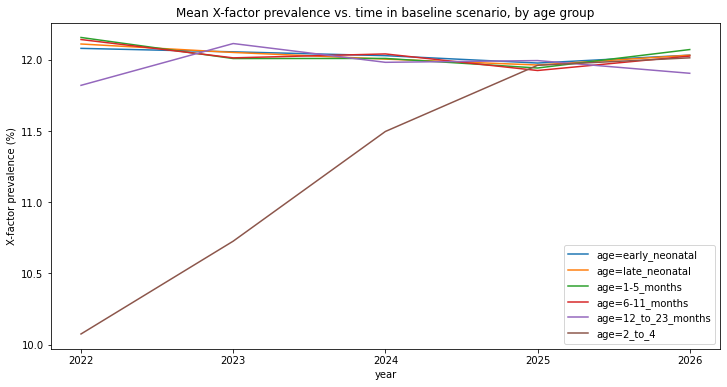

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
# x_factor_effect=1.1
title = "Mean X-factor prevalence vs. time in baseline scenario, by age group"
csp.plot_over_time_by_column(
    x_factor_prevalence.query(f"scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'X-factor prevalence (%)',
    title,
    False
)
# figs['x_factor_prevalence_by_age_group_in_baseline'] = fig
figs[title] = fig

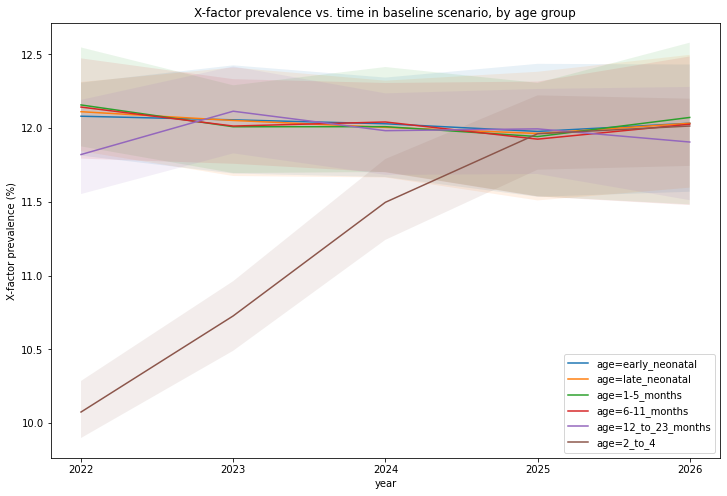

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
title = "X-factor prevalence vs. time in baseline scenario, by age group"
csp.plot_over_time_by_column(
    x_factor_prevalence.query("scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'X-factor prevalence (%)',
    title,
    True
)
figs[title] = fig

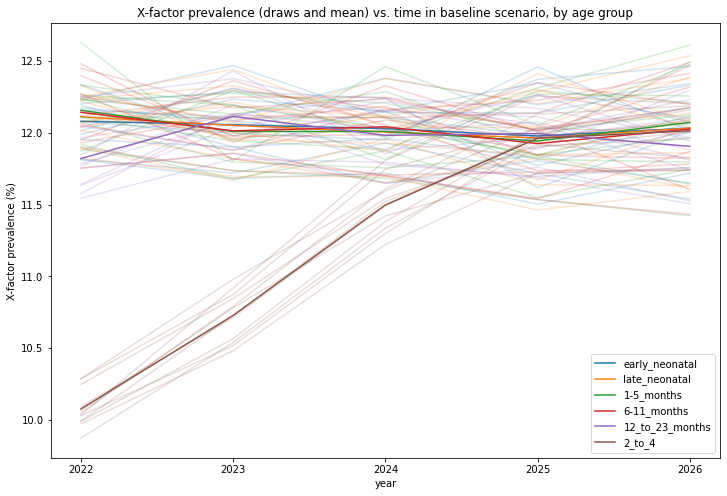

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
title = "X-factor prevalence (draws and mean) vs. time in baseline scenario, by age group"
csp.plot_draws_over_time_by_age(
    x_factor_prevalence.query("scenario=='baseline' and x_factor=='cat1'"),
    'X-factor prevalence (%)',
    title,
)
# figs['x_factor_prevalence_draws_by_age_group_in_baseline'] = fig
figs[title] = fig

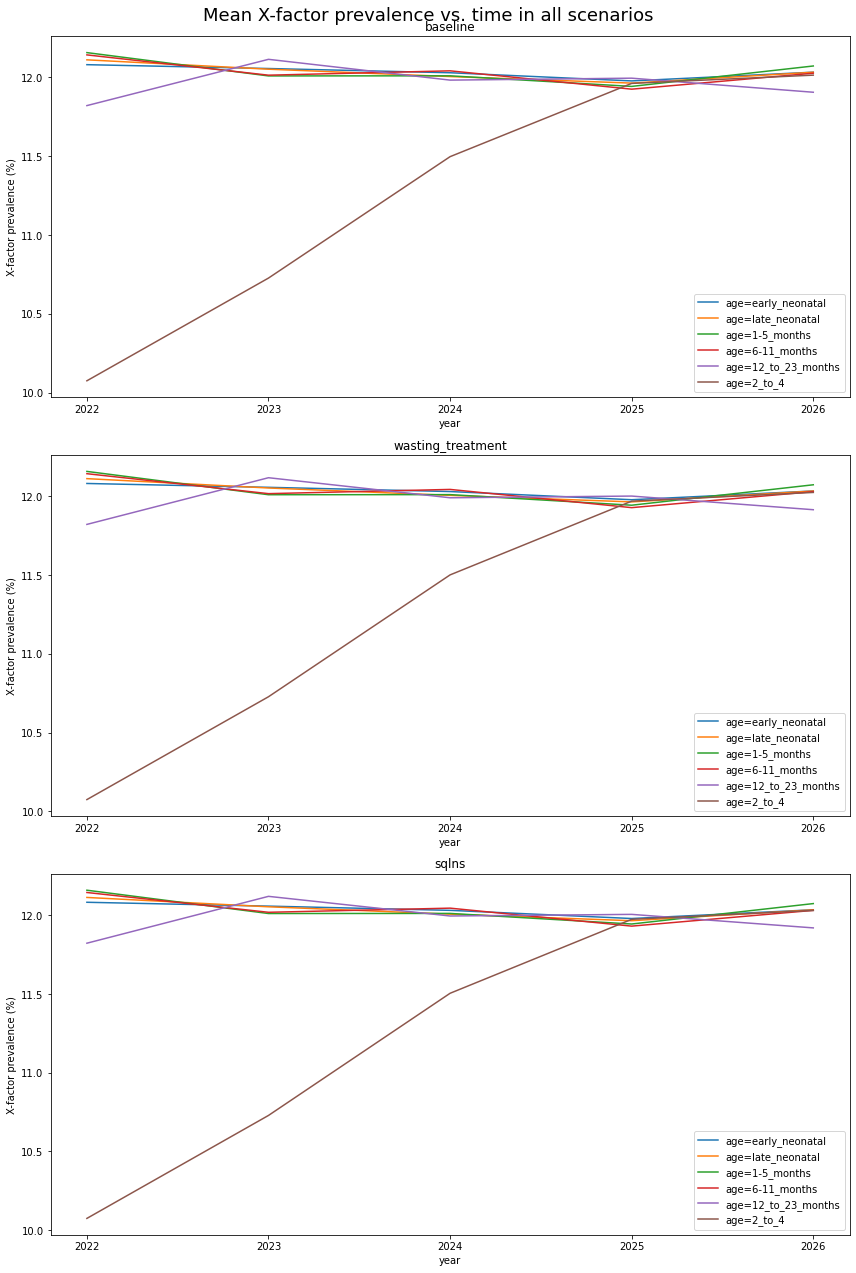

In [11]:
# x_factor_effect=1.5
title = "Mean X-factor prevalence vs. time in all scenarios"
fig = csp.plot_over_time_by_column_for_each_scenario(
    x_factor_prevalence.query(f"x_factor=='cat1'"),
    'age',
    ylabel='X-factor prevalence (%)',
    suptitle=title,
    uncertainty=False,
)
# figs['x_factor_prevalence_by_age_group_in_all_scenarios'] = fig
figs[title] = fig

# Compute X-factor prevalence stratified by year, age, wasting state

In [12]:
# This computes P(X-factor | year, age, wasting_state)
x_factor_prevalence_by_wasting_state = csr.get_prevalence(
    data, 'x_factor', strata=['year', 'age', 'wasting_state'], multiplier=100
)
x_factor_prevalence_by_wasting_state

,year,age,wasting_state,input_draw,scenario,x_factor,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,mild_child_wasting,29,baseline,cat1,25.768590,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,mild_child_wasting,29,baseline,cat2,74.231410,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,mild_child_wasting,29,sqlns,cat1,25.768590,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,mild_child_wasting,29,sqlns,cat2,74.231410,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...,...
8636,2026,late_neonatal,susceptible_to_child_wasting,946,sqlns,cat1,1.114451,state_person_time,state_person_time,100,prevalence
8637,2026,late_neonatal,susceptible_to_child_wasting,946,sqlns,cat2,98.885549,state_person_time,state_person_time,100,prevalence
8638,2026,late_neonatal,susceptible_to_child_wasting,946,wasting_treatment,cat1,1.114451,state_person_time,state_person_time,100,prevalence
8639,2026,late_neonatal,susceptible_to_child_wasting,946,wasting_treatment,cat2,98.885549,state_person_time,state_person_time,100,prevalence


# Plot X-factor prevalence in each wasting state for each age group

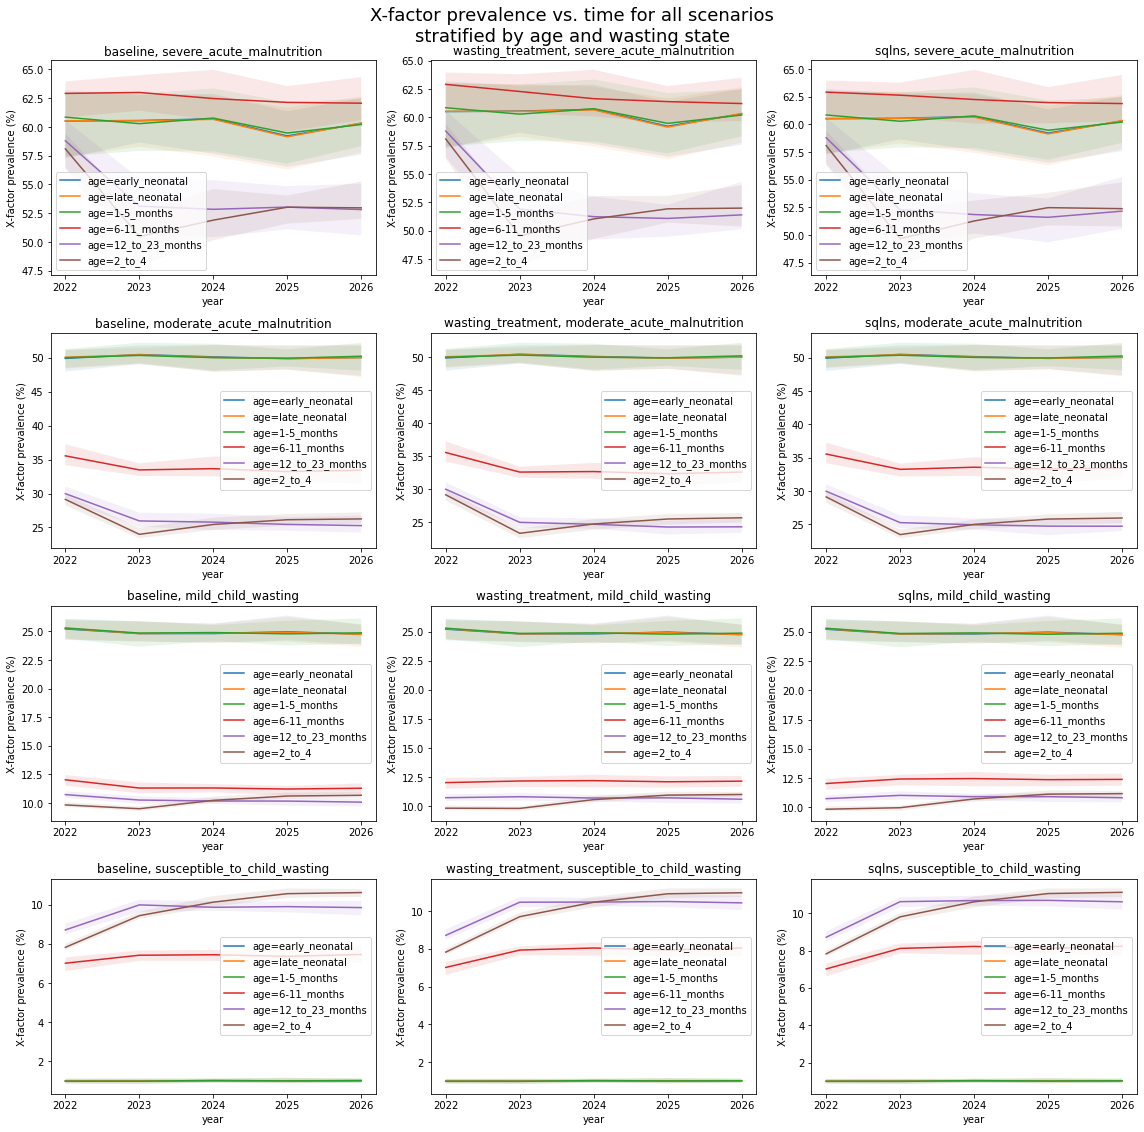

In [13]:
title = "X-factor prevalence vs. time for all scenarios\nstratified by age and wasting state"
fig = csp.plot_over_time_by_column_for_each_wasting_state_and_scenario(
    x_factor_prevalence_by_wasting_state.query("x_factor=='cat1'"),
    colname='age',
    ylabel='X-factor prevalence (%)',
    suptitle=title
)
figs[title] = fig

# Compute the "target" joint prevalence of X-factor and wasting state from the wasting state prevalence, based on the X-factor exposure initialization parameters

X-factor exposure by wasting state: sam=0.6, mam=0.5, mild=0.25, tmrel=0.01

**Caveat:** Note that "target" exposure shouldn't be taken too literally. We really only expect these values to match at the beginning of the sim. See notes in plots below.

In [14]:
wasting_state_prevalence = csr.get_prevalence(
    data, 'wasting_state', ['year', 'age'], multiplier=100,
)
wasting_state_prevalence

,year,age,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,29,baseline,mild_child_wasting,20.592531,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,29,baseline,moderate_acute_malnutrition,8.870594,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,29,baseline,severe_acute_malnutrition,2.871921,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,29,baseline,susceptible_to_child_wasting,67.664954,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
4316,2026,late_neonatal,946,wasting_treatment,mild_child_wasting,19.942760,state_person_time,state_person_time,100,prevalence
4317,2026,late_neonatal,946,wasting_treatment,moderate_acute_malnutrition,8.977209,state_person_time,state_person_time,100,prevalence
4318,2026,late_neonatal,946,wasting_treatment,severe_acute_malnutrition,3.336214,state_person_time,state_person_time,100,prevalence
4319,2026,late_neonatal,946,wasting_treatment,susceptible_to_child_wasting,67.743817,state_person_time,state_person_time,100,prevalence


In [15]:
wasting_state_prevalence.wasting_state.unique()

array(['mild_child_wasting', 'moderate_acute_malnutrition',
       'severe_acute_malnutrition', 'susceptible_to_child_wasting'],
      dtype=object)

In [16]:
# These match the values in model_specification.yaml -- see the final cell of the notebook
x_factor_initial_exposures = {
    'severe_acute_malnutrition': 0.6,
    'moderate_acute_malnutrition': 0.5,
    'mild_child_wasting': 0.25,
    'susceptible_to_child_wasting': 0.01,
}

# This computes the "target" joint prevalence of X factor and wasting state, stratified by
# year and age, i.e. the conditional probability target_prevalence(X-factor, wasting_state | year, age),
# where the target_prevalence measure is determined by the above fractions of each wasting state.
# See the analogous computation for the simulation results below.
x_factor_wasting_state_target_exposure = wasting_state_prevalence.assign(
    value=lambda df: df['value'] * df['wasting_state'].map(x_factor_initial_exposures)
)
x_factor_wasting_state_target_exposure

,year,age,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,29,baseline,mild_child_wasting,5.148133,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,29,baseline,moderate_acute_malnutrition,4.435297,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,29,baseline,severe_acute_malnutrition,1.723153,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,29,baseline,susceptible_to_child_wasting,0.676650,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
4316,2026,late_neonatal,946,wasting_treatment,mild_child_wasting,4.985690,state_person_time,state_person_time,100,prevalence
4317,2026,late_neonatal,946,wasting_treatment,moderate_acute_malnutrition,4.488605,state_person_time,state_person_time,100,prevalence
4318,2026,late_neonatal,946,wasting_treatment,severe_acute_malnutrition,2.001728,state_person_time,state_person_time,100,prevalence
4319,2026,late_neonatal,946,wasting_treatment,susceptible_to_child_wasting,0.677438,state_person_time,state_person_time,100,prevalence


In [17]:
x_factor_target_exposure = vp.marginalize(x_factor_wasting_state_target_exposure, 'wasting_state')
x_factor_target_exposure

,age,denominator_measure,input_draw,measure,multiplier,numerator_measure,scenario,year,value
0,1-5_months,state_person_time,29,prevalence,100,state_person_time,baseline,2022,11.983232
1,1-5_months,state_person_time,29,prevalence,100,state_person_time,baseline,2023,11.940846
2,1-5_months,state_person_time,29,prevalence,100,state_person_time,baseline,2024,12.072090
3,1-5_months,state_person_time,29,prevalence,100,state_person_time,baseline,2025,11.978475
...,...,...,...,...,...,...,...,...,...
1076,late_neonatal,state_person_time,946,prevalence,100,state_person_time,wasting_treatment,2023,12.130690
1077,late_neonatal,state_person_time,946,prevalence,100,state_person_time,wasting_treatment,2024,12.195561
1078,late_neonatal,state_person_time,946,prevalence,100,state_person_time,wasting_treatment,2025,12.135038
1079,late_neonatal,state_person_time,946,prevalence,100,state_person_time,wasting_treatment,2026,12.153461


# Plot "target" overall X-factor exposure in each age group based on the X-factor exposure initialization parameters

**Caveat:** Note that "target" exposure shouldn't be taken too literally. In particular, when stratified by year in the alternative scenarios, this "target" exposure will decrease after the intervention starts because the prevalence of SAM and MAM will decrease, and the values here are computed as a fixed fraction of each wasting state prevalence. But we don't necessarily expect the X-factor prevalence in the simulation to track this proportion over time, because people's X-factor exposure doesn't change when they move from SAM or MAM back into MILD. Rather, it's more just the initial exposures that we expect to match, and I think we'd expect the overall X-factor prevalence to remain fairly constant over time, though I'm not sure how to accurately reason about how the overall X-factor prevalence should evolve.

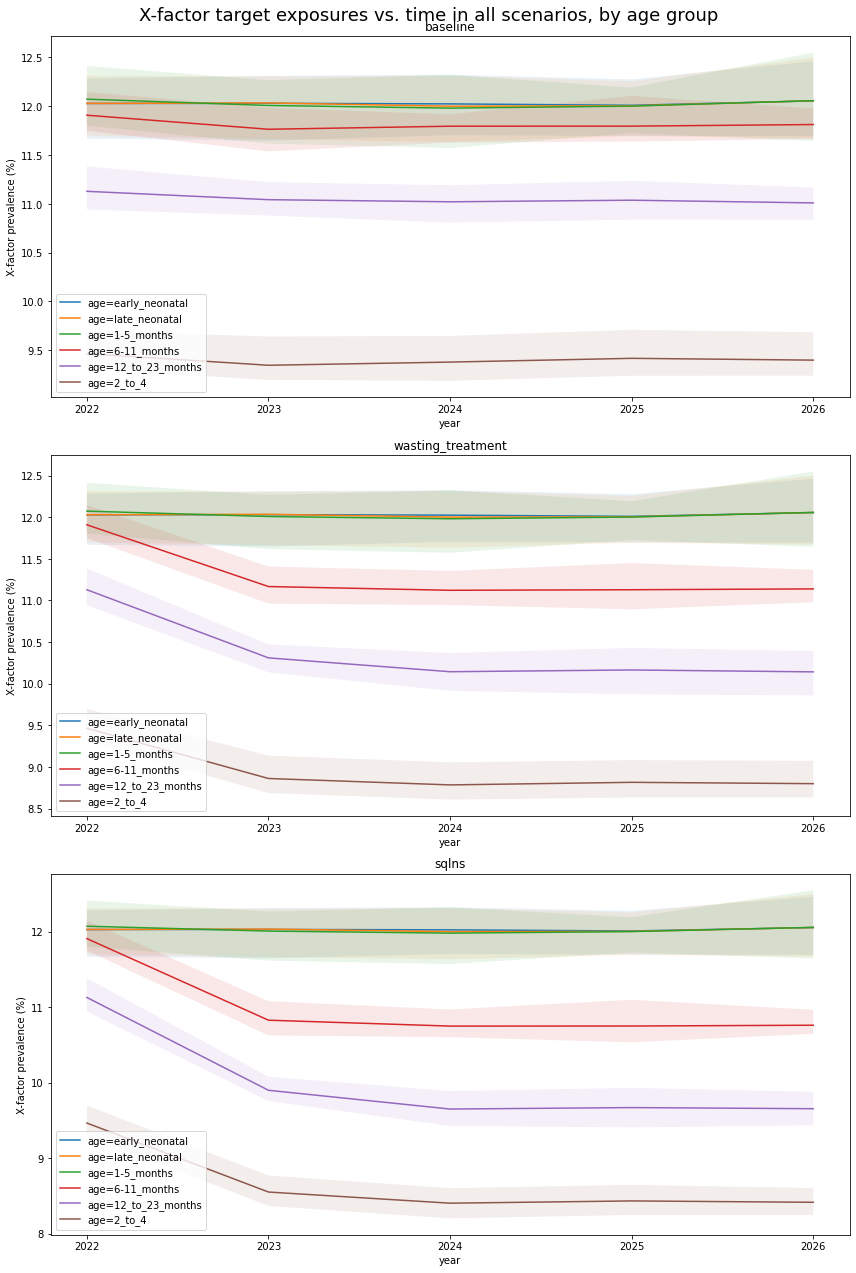

In [18]:
# fig, ax = plt.subplots(figsize=(12,6))
title = "X-factor target exposures vs. time in all scenarios, by age group"
fig = csp.plot_over_time_by_column_for_each_scenario(
    x_factor_target_exposure,
    'age',
    'X-factor prevalence (%)',
    title,
    True
);
figs[title] = fig

# Plot "target" joint prevalence of X-factor and wasing state, stratified by year and age

**Caveat:** Note that "target" exposure shouldn't be taken too literally. See note in plot above, and see plot of simulated joint probabilities below.

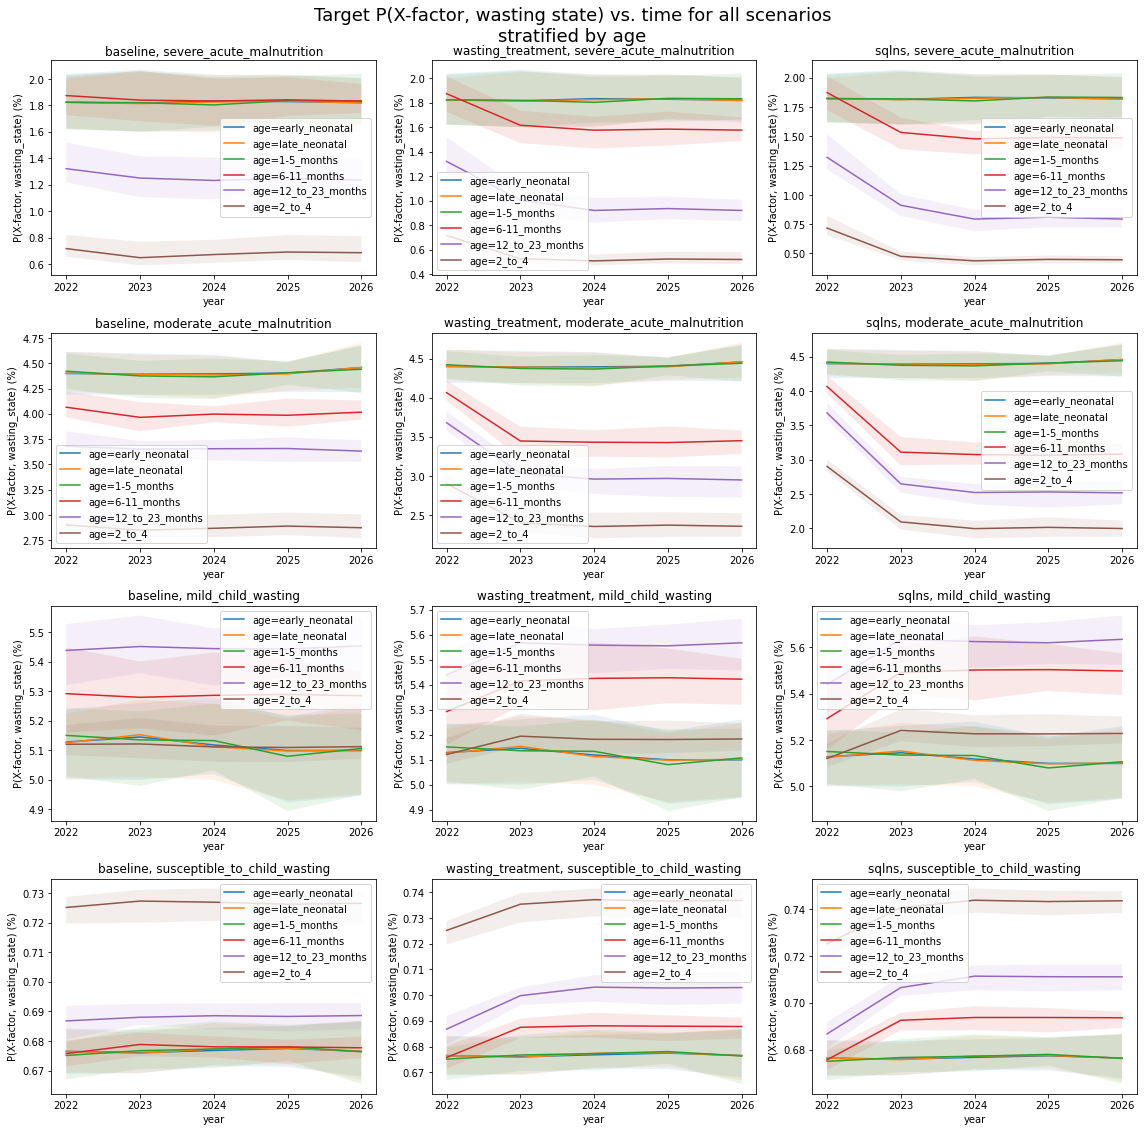

In [19]:
title = "Target P(X-factor, wasting state) vs. time for all scenarios\nstratified by age"
fig = csp.plot_over_time_by_column_for_each_wasting_state_and_scenario(
    x_factor_wasting_state_target_exposure,
    'age',
    'P(X-factor, wasting_state) (%)',
    title,
    True
)
figs[title] = fig

# Compute joint (X-factor, wasting_state) prevalence stratified by year and age group, and plot it

**Caveat:** We don't necessarily expect this plot to exactly match the plot of "target" joint probabilities above. They are similar, but there are some definite differences. I'm not sure how to reason about exactly what the differences should be.

**Plan for future code update** to `get_prevalence`: It would be more intuitive to be able to compute a joint prevalence like this by passing `['x_factor', 'wasting_state']` to `state_variable`, rather than having to pass one of the variables to `state_variable` and the other(s) to `numerator_broadcast`.

In [20]:
# This computes P(X-factor, wasting_state | year, age),
# i.e. P(X-factor | wasting_state, year, age) * P(wasting_state | year, age)
x_factor_wasting_state_prevalence = csr.get_prevalence(
    data, 'x_factor', strata=['year', 'age'], numerator_broadcast='wasting_state', multiplier=100
)
x_factor_wasting_state_prevalence

,year,age,input_draw,scenario,x_factor,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,29,baseline,cat1,mild_child_wasting,5.306405,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,29,baseline,cat1,moderate_acute_malnutrition,4.482475,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,29,baseline,cat1,severe_acute_malnutrition,1.761105,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,29,baseline,cat1,susceptible_to_child_wasting,0.693044,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...,...
8636,2026,late_neonatal,946,wasting_treatment,cat2,mild_child_wasting,14.822747,state_person_time,state_person_time,100,prevalence
8637,2026,late_neonatal,946,wasting_treatment,cat2,moderate_acute_malnutrition,4.314868,state_person_time,state_person_time,100,prevalence
8638,2026,late_neonatal,946,wasting_treatment,cat2,severe_acute_malnutrition,1.335528,state_person_time,state_person_time,100,prevalence
8639,2026,late_neonatal,946,wasting_treatment,cat2,susceptible_to_child_wasting,66.988845,state_person_time,state_person_time,100,prevalence


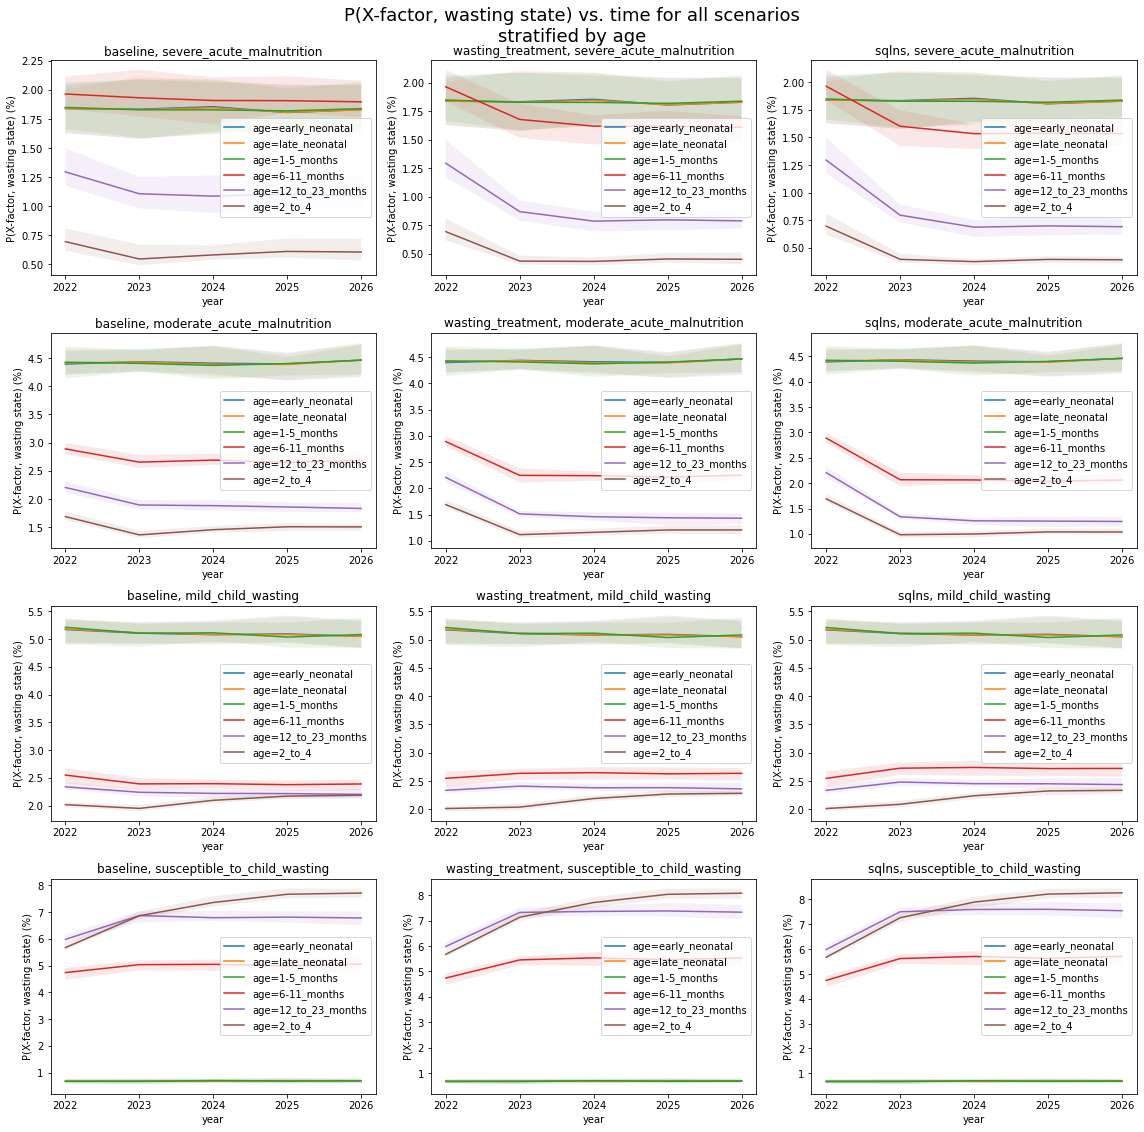

In [21]:
title = "P(X-factor, wasting state) vs. time for all scenarios\nstratified by age"
fig = csp.plot_over_time_by_column_for_each_wasting_state_and_scenario(
    x_factor_wasting_state_prevalence.query("x_factor=='cat1'"),
    colname='age',
    ylabel='P(X-factor, wasting state) (%)',
    suptitle=title
)
figs[title] = fig

# Define directories for saving figures

In [22]:
# project_results_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam'
model_name = 'v4.5.3_x_factor_targeted_exposure'
model_timestamp = '2021_11_02_20_09_56'
username = 'ndbs'

In [23]:
# model_count_data_dir = f'{project_results_dir}/{model_name}/ciff_sam/{model_timestamp}/count_data/'

project_vv_directory_name = 'ciff_malnutrition/verification_and_validation'

output_dir = f'/ihme/homes/{username}/vivarium_results/{project_vv_directory_name}/{model_name}'
share_output_dir = f'/share/scratch/users/ndbs/vivarium_results/{project_vv_directory_name}/{model_name}'
j_output_dir = f'/home/j/Project/simulation_science/{project_vv_directory_name}/{model_name}'

# Create the output directories if they don't exist
# Note from Path.mkdir() documentation:
#   "If mode is given, it is combined with the process’ umask value to determine the file mode and access flags."
#
# I don't know what this notebook process' umask value will be, so I don't know if this will actually result
# in the correct (most permissive) permissions for the directories...
for directory in [output_dir, share_output_dir, j_output_dir]:
    Path(directory).mkdir(mode=0o777, parents=True, exist_ok=True)

In [24]:
# We'll use this function to format the figures' title strings into legitimate file names for saving.
def convert_to_variable_name(string):
    """Converts a string to a valid Python variable.
    Runs of non-word characters (regex matchs \W+) are converted to '_', and '_' is appended to the
    beginning of the string if the string starts with a digit (regex matches ^(?=\d)).
    Solution copied from here:
    https://stackoverflow.com/questions/3303312/how-do-i-convert-a-string-to-a-valid-variable-name-in-python
    """
    return re.sub('\W+|^(?=\d)', '_', string)
convert_to_variable_name(title)

'P_X_factor_wasting_state_vs_time_for_all_scenarios_stratified_by_age'

# Save figures to my home directory and J drive

In [25]:
# We'll use figure titles as filenames, but we'll remove non-word characters first
list(figs.keys())

['Mean X-factor prevalence vs. time in baseline scenario, by age group',
 'X-factor prevalence vs. time in baseline scenario, by age group',
 'X-factor prevalence (draws and mean) vs. time in baseline scenario, by age group',
 'Mean X-factor prevalence vs. time in all scenarios',
 'X-factor prevalence vs. time for all scenarios\nstratified by age and wasting state',
 'X-factor target exposures vs. time in all scenarios, by age group',
 'Target P(X-factor, wasting state) vs. time for all scenarios\nstratified by age',
 'P(X-factor, wasting state) vs. time for all scenarios\nstratified by age']

In [26]:
for figure_name, fig in figs.items():
    for directory in [output_dir, j_output_dir]: 
        fig.savefig(f"{directory}/{convert_to_variable_name(figure_name)}.pdf")

In [27]:
!ls /home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v4.5.3_x_factor_targeted_exposure/


Mean_X_factor_prevalence_vs_time_in_all_scenarios.pdf
Mean_X_factor_prevalence_vs_time_in_baseline_scenario_by_age_group.pdf
P_X_factor_wasting_state_vs_time_for_all_scenarios_stratified_by_age.pdf
Target_P_X_factor_wasting_state_vs_time_for_all_scenarios_stratified_by_age.pdf
X_factor_prevalence_draws_and_mean_vs_time_in_baseline_scenario_by_age_group.pdf
X_factor_prevalence_vs_time_for_all_scenarios_stratified_by_age_and_wasting_state.pdf
X_factor_prevalence_vs_time_in_baseline_scenario_by_age_group.pdf
X_factor_target_exposures_vs_time_in_all_scenarios_by_age_group.pdf


# Load model spec yaml file...

...and experiment with displaying the contents.

Turns out you can simply do

```Python
print(yaml.dump(model_spec))
```

after loading the `model_specification.yaml` file into a dictionary called `model_spec`.

With the output stream parameter of `yaml.dump()` set to `None` (default) and with `default_flow_style=False` (which is the [default if the yaml data has nested collections](https://pyyaml.org/wiki/PyYAMLDocumentation#FrequentlyAskedQuestions)), calling `yaml.dump()` on the loaded dictionary returns a string that is the same as the contents of the original `.yaml` file as returned by `file.read()`.

In [28]:
count_data_path = csr.get_count_data_path('4.5.3')
count_data_path

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.3_x_factor_targeted_exposure/ciff_sam/2021_11_02_20_09_56/count_data/'

In [29]:
output_path = count_data_path[:-len('count_data/')]
output_path

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.3_x_factor_targeted_exposure/ciff_sam/2021_11_02_20_09_56/'

In [30]:
!ls /ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.3_x_factor_targeted_exposure/ciff_sam/2021_11_02_20_09_56/

branches.yaml  logs			 __pycache__
count_data     model_specification.yaml  requirements.txt
keyspace.yaml  output.hdf		 settings.py


In [31]:
model_spec_path = f"{output_path}/model_specification.yaml"
with open(model_spec_path, 'r') as model_spec_file:
    model_spec = yaml.safe_load(model_spec_file) # Load contents into a nested dictionary
type(model_spec)

dict

In [32]:
# This shows what's in the model spec, but the formatting isn't great
model_spec

{'components': {'vivarium_ciff_sam': {'components': ['ChildWasting()',
    'LowBirthWeight()',
    'ShortGestation()',
    "DiseaseEffect('risk_factor.child_wasting', 'risk_factor.x_factor.exposure_parameters')",
    'SQLNSTreatment()',
    'SQLNSIntervention()',
    'WastingTreatmentIntervention()',
    "DisabilityObserver('wasting')",
    "MortalityObserver('wasting')",
    "DiseaseObserver('diarrheal_diseases', 'wasting')",
    "DiseaseObserver('measles', 'wasting')",
    "DiseaseObserver('lower_respiratory_infections', 'wasting')",
    "DiseaseObserver('child_wasting', 'False', 'sq_lns', 'wasting_treatment', 'x_factor')",
    "CategoricalRiskObserver('child_stunting', 'False', 'sq_lns')"]},
  'vivarium_public_health': {'disease': ["SIS('diarrheal_diseases')",
    "SIS_fixed_duration('measles', '10.0')",
    "SIS('lower_respiratory_infections')"],
   'population': ['BasePopulation()',
    'Mortality()',
    'FertilityCrudeBirthRate()'],
   'risks': ["RiskEffect('risk_factor.child_wa

In [33]:
# Instead we can use yaml.dump() to produce a nicely formatted string
# Writing this string to file would produce a valid .yaml file
print(yaml.dump(model_spec))

components:
  vivarium_ciff_sam:
    components:
    - ChildWasting()
    - LowBirthWeight()
    - ShortGestation()
    - DiseaseEffect('risk_factor.child_wasting', 'risk_factor.x_factor.exposure_parameters')
    - SQLNSTreatment()
    - SQLNSIntervention()
    - WastingTreatmentIntervention()
    - DisabilityObserver('wasting')
    - MortalityObserver('wasting')
    - DiseaseObserver('diarrheal_diseases', 'wasting')
    - DiseaseObserver('measles', 'wasting')
    - DiseaseObserver('lower_respiratory_infections', 'wasting')
    - DiseaseObserver('child_wasting', 'False', 'sq_lns', 'wasting_treatment', 'x_factor')
    - CategoricalRiskObserver('child_stunting', 'False', 'sq_lns')
  vivarium_public_health:
    disease:
    - SIS('diarrheal_diseases')
    - SIS_fixed_duration('measles', '10.0')
    - SIS('lower_respiratory_infections')
    population:
    - BasePopulation()
    - Mortality()
    - FertilityCrudeBirthRate()
    risks:
    - RiskEffect('risk_factor.child_wasting', 'cause.di

In [34]:
# Read entire file into a string to compare with yaml.dump()
# They're identical
with open(model_spec_path, 'r') as model_spec_file:
    model_spec_contents = model_spec_file.read()

model_spec_contents == yaml.dump(model_spec)

True

# And finally, the reason I was interested in the model specification yaml file in the first place: Did I use the right parameters for my initial X-factor exposures above?

Yes.

In [35]:
model_spec['configuration']['effect_of_child_wasting_on_x_factor']['exposure_parameters']

{'mild_child_wasting': 0.25,
 'moderate_acute_malnutrition': 0.5,
 'severe_acute_malnutrition': 0.6,
 'susceptible_to_child_wasting': 0.01}

In [36]:
(model_spec['configuration']['effect_of_child_wasting_on_x_factor']['exposure_parameters']
 == x_factor_initial_exposures
)

True